# Taller: Aplicación de Machine Learning en PLN
## Integrantes:
- Nicolas Santiago Acosta Parra
- Anderson Giovany Carreño Rincon
- Johan Sebastián Gil Salmanca
- Edison Ferney Gutierrez Buitrago

## Cargar librerías necesarias

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
import re

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print('Librerías cargadas correctamente')

[nltk_data] Downloading package punkt to C:\Users\Edison
[nltk_data]     Gutierrez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Edison
[nltk_data]     Gutierrez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Edison
[nltk_data]     Gutierrez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Edison
[nltk_data]     Gutierrez\AppData\Roaming\nltk_data...


Librerías cargadas correctamente


[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Edison
[nltk_data]     Gutierrez\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 1) Cargar dataset

In [26]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

categories_sports = ['rec.sport.baseball', 'rec.sport.hockey']
categories_non_sports = ['sci.med', 'comp.graphics']

newsgroups_train = fetch_20newsgroups(subset='train', 
                                      categories=categories_sports + categories_non_sports,
                                      shuffle=True, 
                                      random_state=42)

newsgroups_test = fetch_20newsgroups(subset='test', 
                                     categories=categories_sports + categories_non_sports,
                                     shuffle=True, 
                                     random_state=42)

df_train = pd.DataFrame({
    'text': newsgroups_train.data,
    'category': [newsgroups_train.target_names[i] for i in newsgroups_train.target],
    'is_sports': [1 if 'sport' in newsgroups_train.target_names[i] else 0 
                  for i in newsgroups_train.target]
})

df_test = pd.DataFrame({
    'text': newsgroups_test.data,
    'category': [newsgroups_test.target_names[i] for i in newsgroups_test.target],
    'is_sports': [1 if 'sport' in newsgroups_test.target_names[i] else 0 
                  for i in newsgroups_test.target]
})


df = pd.concat([df_train, df_test], ignore_index=True)
df.head()

print(f"\nINFORMACIÓN DEL DATASET")
print(f"Total de documentos: {len(df)}")
print(f"Documentos de entrenamiento: {len(df_train)}")
print(f"Documentos de prueba: {len(df_test)}")
print(f"\nDistribución por categoría:")
print(df['category'].value_counts())
print(f"\nDistribución Sports vs No-Sports:")
print(df['is_sports'].value_counts())

print("\nEJEMPLO DE TEXTO DEPORTIVO:")
print(df[df['is_sports']==1]['text'].iloc[0][:500])


INFORMACIÓN DEL DATASET
Total de documentos: 3956
Documentos de entrenamiento: 2375
Documentos de prueba: 1581

Distribución por categoría:
category
rec.sport.hockey      999
rec.sport.baseball    994
sci.med               990
comp.graphics         973
Name: count, dtype: int64

Distribución Sports vs No-Sports:
is_sports
1    1993
0    1963
Name: count, dtype: int64

EJEMPLO DE TEXTO DEPORTIVO:
From: tedward@cs.cornell.edu (Edward [Ted] Fischer)
Subject: Re: Ind. Source Picks Baerga Over Alomar: Case Closed 
Organization: Cornell Univ. CS Dept, Ithaca NY 14853
Distribution: na
Lines: 24

In article <C5L6Dn.4uB@andy.bgsu.edu> klopfens@andy.bgsu.edu (Bruce Klopfenstein) writes:
>fester@island.COM (Mike Fester) writes:
>> 
>> I'd say you could make a good for them being about equal right now. T&P
>> rated Baerga higher, actually.
>
>Finally, an objective source.  Alomar's a great player, 


## 2) Preprocesamiento

En este apartado se realiza la limpieza de los textos: minúsculas, sin símbolos, sin stopwords, tokenizamos y lematizamos.

In [27]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_text(text):
    """
    Limpia el texto eliminando elementos no deseados
    """
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Función de tokenización
def tokenize_text(text):
    """
    Tokeniza el texto en palabras individuales
    """
    tokens = word_tokenize(text)
    return tokens

# Función para eliminar stopwords
def remove_stopwords(tokens):
    """
    Elimina palabras comunes sin significado relevante
    """
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return filtered_tokens

# Función de lematización
def lemmatize_tokens(tokens):
    """
    Reduce palabras a su forma base (lemma)
    """
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

# Función de stemming (alternativa)
def stem_tokens(tokens):
    """
    Reduce palabras a su raíz (stem)
    """
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(token) for token in tokens]
    return stemmed

# Pipeline completo de preprocesamiento
def preprocess_pipeline(text, use_lemmatization=True):
    """
    Pipeline completo de preprocesamiento
    """
    # 1. Limpiar texto
    text = clean_text(text)
    
    # 2. Tokenizar
    tokens = tokenize_text(text)
    
    # 3. Eliminar stopwords
    tokens = remove_stopwords(tokens)
    
    # 4. Lematización o Stemming
    if use_lemmatization:
        tokens = lemmatize_tokens(tokens)
    else:
        tokens = stem_tokens(tokens)
    
    # 5. Unir tokens de nuevo en texto
    processed_text = ' '.join(tokens)
    
    return processed_text


#def limpiar_texto(texto):
#    texto = str(texto).lower()
#    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)
#    texto = re.sub(r'[^a-z\s]', '', texto)
#    tokens = nltk.word_tokenize(texto)
#    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 1]
#    return ' '.join(tokens)

df['texto_limpio'] = df['text'].apply(preprocess_pipeline)
df.head()

,text,category,is_sports,texto_limpio
0,From: tedward@cs.cornell.edu (Edward [Ted] Fis...,rec.sport.baseball,1,edward ted fischer subject ind source pick bae...
1,From: Mark W. Dubin\nSubject: Re: Barbecued fo...,sci.med,0,mark dubin subject barbecued food health risk ...
2,From: chuck@cygnus.eid.anl.gov (Charles Cilek)...,rec.sport.baseball,1,charles cilek subject slugging percentage comp...
3,From: CROSEN1@ua1vm.ua.edu (Charles Rosen)\nSu...,rec.sport.baseball,1,charles rosen subject torre worst manager nntp...
4,From: jrogoff@scott.skidmore.edu (jay rogoff)\...,rec.sport.baseball,1,jay rogoff subject best homeruns distribution ...


## 3) Representación del texto

Se usa Bag of Words (CountVectorizer) y TF-IDF (TfidfVectorizer) para convertir texto a vectores.

In [28]:
# Vectorizadores
X = df['texto_limpio']
y = df['is_sports']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

bow = CountVectorizer()
tfidf = TfidfVectorizer(max_features=500)


X_train_bow = bow.fit_transform(X_train)      
X_test_bow = bow.transform(X_test)


X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)  

print('Tamaño X_train_bow:', X_train_bow.shape)
print('Tamaño X_test_bow:', X_test_bow.shape)
print('Tamaño X_train_tfidf:', X_train_tfidf.shape)
print('Tamaño X_test_tfidf:', X_test_tfidf.shape)

Tamaño X_train_bow: (2769, 32228)
Tamaño X_test_bow: (1187, 32228)
Tamaño X_train_tfidf: (2769, 500)
Tamaño X_test_tfidf: (1187, 500)


## Optimización de parámetros

In [29]:
##OPTIMIZACIÓN DE PARÁMETROS
#
#from sklearn.model_selection import GridSearchCV
#from sklearn.naive_bayes import MultinomialNB
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import classification_report
#
## =====================================================
## GRID SEARCH - NAIVE BAYES
## =====================================================
#param_nb = {
#    'alpha': [0.01, 0.1, 0.5, 1.0],
#    'fit_prior': [True, False]
#}
#
#grid_nb = GridSearchCV(
#    MultinomialNB(),
#    param_grid=param_nb,
#    cv=5,
#    scoring='f1',
#    n_jobs=-1
#)
#grid_nb.fit(X_train_tfidf, y_train)
#
#print("\nMejor configuración Naive Bayes:", grid_nb.best_params_)
#
#
## =====================================================
## GRID SEARCH - REGRESIÓN LOGÍSTICA
## =====================================================
#param_lr = {
#    'C': [0.01, 0.1, 1, 10],
#    'penalty': ['l2'],
#    'solver': ['liblinear', 'saga'],
#    'class_weight': [None, 'balanced']
#}
#
#grid_lr = GridSearchCV(
#    LogisticRegression(max_iter=2000, random_state=42),
#    param_grid=param_lr,
#    cv=5,
#    scoring='f1',
#    n_jobs=-1
#)
#grid_lr.fit(X_train_tfidf, y_train)
#
#print("\nMejor configuración Regresión Logística:", grid_lr.best_params_)
#
#
## =====================================================
## GRID SEARCH - RANDOM FOREST
## =====================================================
#param_rf = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 20, 50],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['sqrt', 'log2'],
#    'class_weight': [None, 'balanced']
#}
#
#grid_rf = GridSearchCV(
#    RandomForestClassifier(random_state=42),
#    param_grid=param_rf,
#    cv=5,
#    scoring='f1',
#    n_jobs=-1
#)
#grid_rf.fit(X_train_tfidf, y_train)
#
#print("\nMejor configuración Random Forest:", grid_rf.best_params_)
#from sklearn.model_selection import cross_val_score
#import numpy as np

## 4) División de datos y entrenamiento de modelos

Se divide los datos en entrenamiento y prueba para posteriormente probar los distintos modelos.

Modelos: Naive Bayes, Regresión Logística y Random Forest.

Se usa TF-IDF por defecto para entrenar.

In [30]:
models = { 
    'Naive Bayes': MultinomialNB(alpha=0.01, fit_prior=True),

    'Regresión Logística': LogisticRegression(
        C=10,
        class_weight=None,
        penalty='l2',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    ),

    'Random Forest': RandomForestClassifier(class_weight=None, n_estimators=100, max_depth=50, max_features='log2', min_samples_leaf=1, min_samples_split=2, random_state=42, n_jobs=-1
    )
}
resultados = {}

for nombre, modelo in models.items():
    modelo.fit(X_train_tfidf, y_train)
    y_pred = modelo.predict(X_test_tfidf)
    resultados[nombre] = (modelo, y_pred)
    print(f"\nResultado: {nombre}")
    print(classification_report(y_test, y_pred))



Resultado: Naive Bayes
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       589
           1       0.97      0.97      0.97       598

    accuracy                           0.97      1187
   macro avg       0.97      0.97      0.97      1187
weighted avg       0.97      0.97      0.97      1187


Resultado: Regresión Logística
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       589
           1       0.97      0.96      0.97       598

    accuracy                           0.97      1187
   macro avg       0.97      0.97      0.97      1187
weighted avg       0.97      0.97      0.97      1187


Resultado: Random Forest
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       589
           1       0.99      0.95      0.97       598

    accuracy                           0.97      1187
   macro avg       0.97      0.97      0.97   

## 5) Matrices de confusión

Se muestra una matriz por cada modelo.

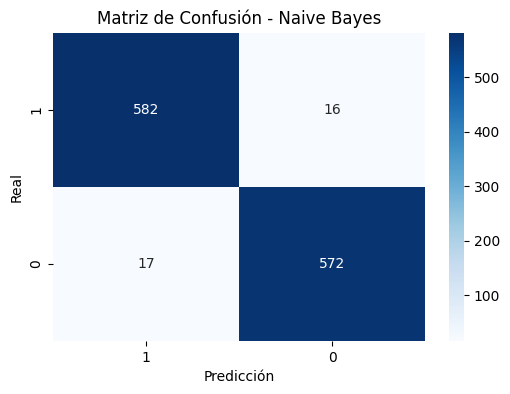

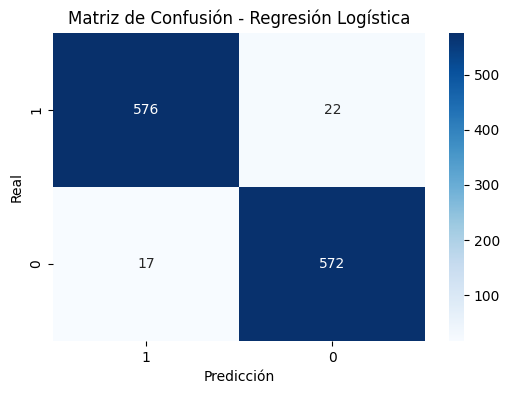

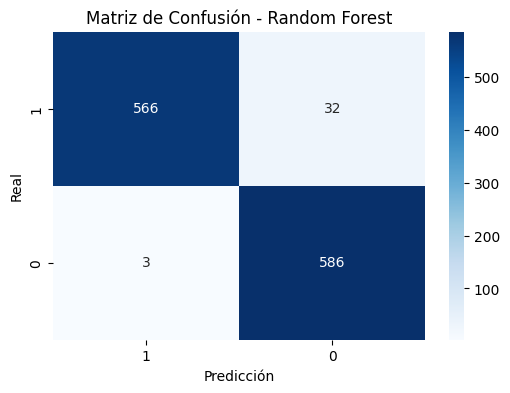

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

for nombre, (modelo, y_pred) in resultados.items():
    cm = confusion_matrix(y_test, y_pred, labels=y.unique())
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=y.unique(), yticklabels=y.unique(), cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()


## 6) WordClouds por categoría

Visualizar términos frecuentes por categoría.

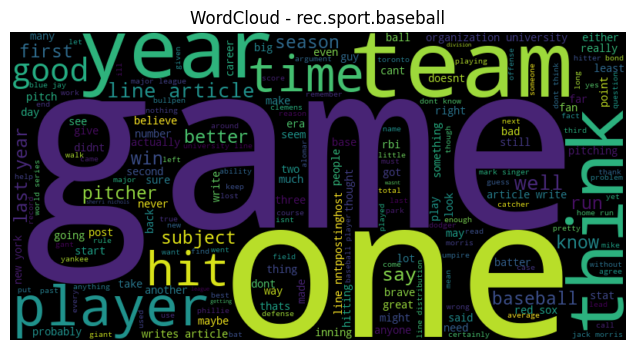

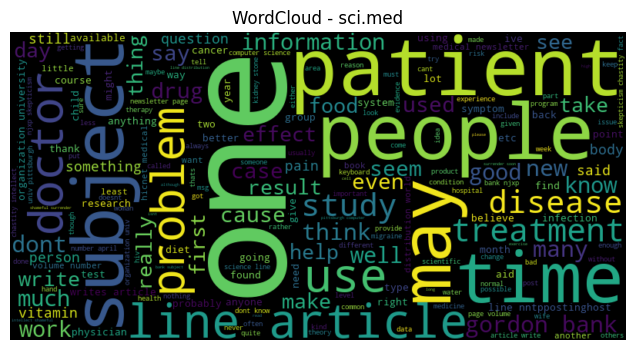

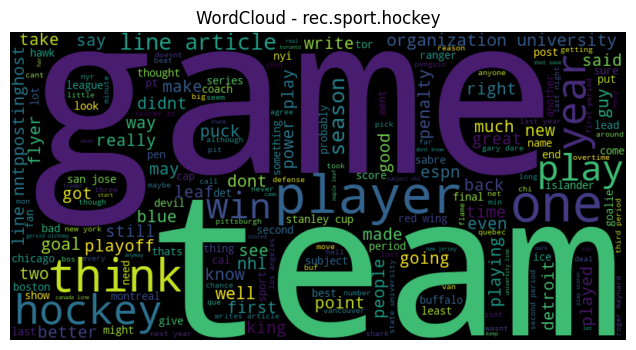

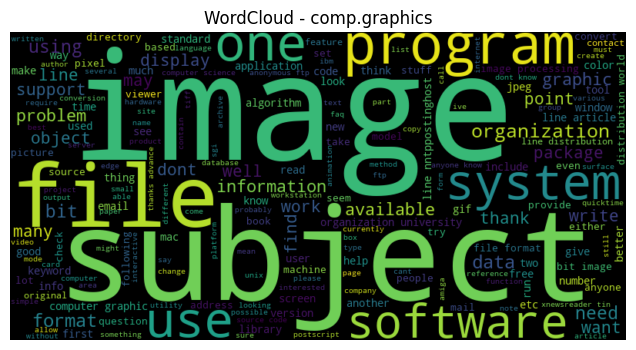

In [32]:
from wordcloud import WordCloud

for cat in df['category'].unique():
    texto_cat = ' '.join(df[df['category']==cat]['texto_limpio'])
    if texto_cat.strip() == '':
        continue
    wc = WordCloud(width=800, height=400).generate(texto_cat)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud - {cat}')
    plt.show()


## 7) Curva ROC / AUC 

Para problemas multicategoría calculamos AUC por clase usando decision_function o predict_proba cuando esté disponible.

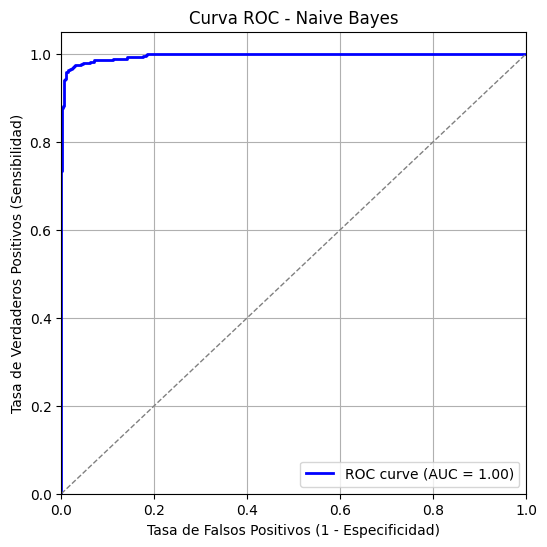

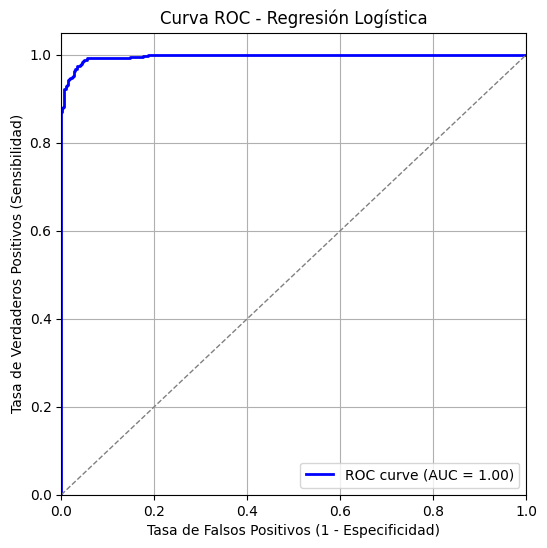

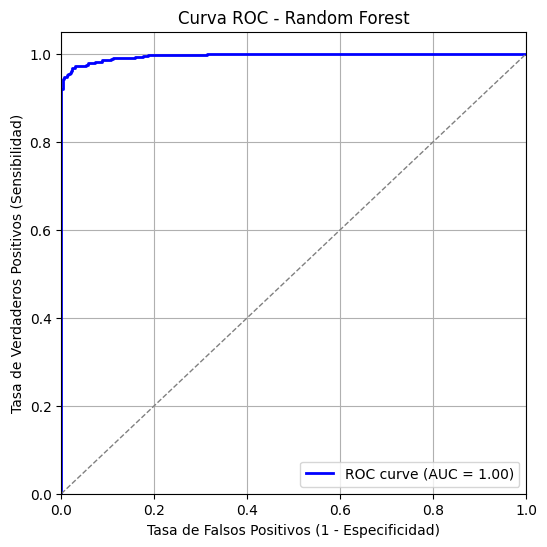

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

for nombre, modelo in models.items():
    y_pred_proba = modelo.predict_proba(X_test_tfidf)[:, 1]

    # Calcular puntos de la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Graficar
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
    plt.title(f'Curva ROC - {nombre}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()



## 8) Guardar resultados y conclusiones

In [34]:
## Ejemplo: guardar predicciones del mejor modelo (por claridad usamos Regresión Logística)
#predicciones = pd.DataFrame({'texto': df.loc[X_test.indices if hasattr(X_test, 'indices') else X_test.shape,'texto'] if False else df.loc[y_test.index,'texto'],
#                             'real': y_test.values,
#                             'pred': resultados['Regresión Logística'][1]})
#
## Mostrar predicciones
#predicciones
#
## Guardar CSV
#predicciones.to_csv('predicciones_pln.csv', index=False)
#print('Predicciones guardadas en el archivo predicciones_pln.csv')

#OPCIÓN 2
#modelo_nombre = 'Regresión Logística'
#y_pred = resultados[modelo_nombre][1]
#
#predicciones = pd.DataFrame({
#    'texto': textos_test,
#    'real': y_test,
#    'pred': y_pred
#})
#
##Guardar en CSV
#predicciones.to_csv('predicciones_pln.csv', index=False)
#print('Predicciones guardadas en el archivo predicciones_pln.csv')

## 9) Conclusiones

- Resumit los resultados de los modelos (precisión, recall, F1).
- Mencionar limitaciones (poca data de ejemplo, desequilibrio posible).
- Sugerencias de mejora: más datos, embeddings (Word2Vec, FastText), modelos preentrenados (BERT), ajuste de hiperparámetros.

In [35]:
#Forma de predecir texto ingresado:
class PredictText:
    
    def predecir_texto(self, texto):
        texto_limpio = preprocess_pipeline(texto)
        vector = tfidf.transform([texto_limpio])
        print()
        print("*"*30)
        print(f"TEXTO: '{texto}'")
        self.final_message = ""
        for nombre, modelo in models.items():
            pred = modelo.predict(vector)[0]
            answer = "Es sobre deportes" if pred == 1 else "No es sobre deportes"
            self.final_message += f"\n- Predicción de {nombre}: {answer}"
            print(f"- Predicción de {nombre}: {answer}")
        message = self.final_message
        self.final_message = ""
        return message

predict = PredictText()
print("-"*35)
print("Textos relacionados con deporte")
print("-"*35)
predict.predecir_texto("Cristiano Ronaldo scored a stunning goal in the final minutes of the game.")
predict.predecir_texto("The Lakers secured another victory with LeBron James leading the scoreboard.")
predict.predecir_texto("Serena Williams announced her retirement after an incredible career in tennis.")
predict.predecir_texto("The World Cup final attracted millions of viewers around the globe.")
predict.predecir_texto("Liverpool’s defense was solid throughout the entire match against Chelsea.")
predict.predecir_texto("The Olympic Games will feature new sports such as skateboarding and surfing.")
predict.predecir_texto("Manchester City lifted the Premier League trophy after a 3-0 win.")
predict.predecir_texto("The coach praised his team’s discipline and teamwork after the victory.")
predict.predecir_texto("A new record was set in the 100-meter sprint by an American athlete.")
predict.predecir_texto("Fans celebrated wildly as their team qualified for the Champions League final.")

print()
print("-"*35)
print("Textos No relacionados con deporte")
print("-"*35)
predict.predecir_texto("The government announced a new plan to improve public transportation.")
predict.predecir_texto("A massive wildfire spread through the northern region causing evacuations.")
predict.predecir_texto("Apple unveiled its latest iPhone model with advanced camera technology.")
predict.predecir_texto("The stock market saw a significant drop due to global economic concerns.")
predict.predecir_texto("Scientists developed a new vaccine that shows promising results.")
predict.predecir_texto("Tourism in Europe is expected to rise during the summer season.")
predict.predecir_texto("The new education policy aims to reduce inequality in rural areas.")
predict.predecir_texto("A famous actor announced his return to Hollywood after a long break.")
predict.predecir_texto("The museum opened a new exhibition about ancient Egyptian culture.")
predict.predecir_texto("Heavy rains caused flooding in several cities across the country.")



-----------------------------------
Textos relacionados con deporte
-----------------------------------

******************************
TEXTO: 'Cristiano Ronaldo scored a stunning goal in the final minutes of the game.'
- Predicción de Naive Bayes: Es sobre deportes
- Predicción de Regresión Logística: Es sobre deportes
- Predicción de Random Forest: Es sobre deportes

******************************
TEXTO: 'The Lakers secured another victory with LeBron James leading the scoreboard.'
- Predicción de Naive Bayes: No es sobre deportes
- Predicción de Regresión Logística: No es sobre deportes
- Predicción de Random Forest: No es sobre deportes

******************************
TEXTO: 'Serena Williams announced her retirement after an incredible career in tennis.'
- Predicción de Naive Bayes: Es sobre deportes
- Predicción de Regresión Logística: No es sobre deportes
- Predicción de Random Forest: No es sobre deportes

******************************
TEXTO: 'The World Cup final attracted mill

'\n- Predicción de Naive Bayes: No es sobre deportes\n- Predicción de Regresión Logística: No es sobre deportes\n- Predicción de Random Forest: No es sobre deportes'

In [59]:
import tkinter as tk
from tkinter import filedialog, messagebox, scrolledtext
from PIL import Image, ImageTk
import PyPDF2
from docx import Document
import os

class SpecialButton(tk.Button):
    
    def __init__(self, root, text, width, primary_color, secondary_color, command=None):
        
        self.base_image = self.create_gradient_image(width, 36, primary_color, secondary_color)
        self.base_image_hover = self.create_gradient_image(width, 36, "#747474", "#292929")
        
        self.gradient_photo = ImageTk.PhotoImage(self.base_image, master=root)
        self.gradient_photo_hover = ImageTk.PhotoImage(self.base_image_hover, master=root)
        
        super().__init__(
            root,
            text=text,
            relief=tk.FLAT,
            bg="#FFFFFF",
            fg="white",
            activebackground=secondary_color,
            activeforeground=secondary_color,
            font=("Segoe UI", 11, "bold"),
            bd=0,
            cursor="hand2",
            image=self.gradient_photo,
            compound="center",
            padx=2, 
            pady=2,
            command=command
        )
        
        self.secondary_color = secondary_color
        
        self.set_events()
    
        
    def set_events(self):
        self.bind("<Enter>", self.on_enter)
        self.bind("<Leave>", self.on_leave)
    
    def on_enter(self, event):
        self.config(image=self.gradient_photo_hover)

    def on_leave(self, event):
        self.config(image=self.gradient_photo)
    
    def create_gradient_image(self, width, height, color1, color2):
        base = Image.new('RGB', (width, height), color1)
        top = Image.new('RGB', (width, height), color2)
        mask = Image.new('L', (width, height))
        for x in range(width):
            for y in range(height):
                mask.putpixel((x, y), int(255 * (x / width)))
        base.paste(top, (0, 0), mask)
        return base

def analizar_texto():
    texto = text_box.get("1.0", tk.END).strip()
    if not texto or texto == placeholder_text:
        messagebox.showwarning("Aviso", "Por favor, ingresa un texto o carga un archivo PDF, DOCX o TXT.")
        return

    pred = predict.predecir_texto(texto)
    messagebox.showinfo("Resultado del análisis", f"El texto se clasifica como: {pred}")


def cargar_archivo():
    archivo = filedialog.askopenfilename(
        filetypes=[
            ("Archivos de texto", "*.pdf *.txt *.docx"),
            ("Todos los archivos", "*.*")
        ]
    )
    if not archivo:
        return

    try:
        extension = os.path.splitext(archivo)[1].lower()
        texto = ""

        if extension == ".pdf":
            with open(archivo, "rb") as f:
                reader = PyPDF2.PdfReader(f)
                for page in reader.pages:
                    texto += page.extract_text() or ""

        elif extension == ".txt":
            with open(archivo, "r", encoding="utf-8", errors="ignore") as f:
                texto = f.read()

        elif extension == ".docx":
            doc = Document(archivo)
            texto = "\n".join([p.text for p in doc.paragraphs])

        else:
            messagebox.showwarning("Formato no soportado", "Solo se admiten archivos PDF, TXT o DOCX.")
            return

        text_box.delete("1.0", tk.END)
        text_box.insert(tk.END, texto)
        text_box.config(fg=default_fg_color)
        
        if not texto:
            on_focus_out(None)
        messagebox.showinfo("Archivo cargado", f"Se ha cargado correctamente el archivo {os.path.basename(archivo)}")

    except Exception as e:
        messagebox.showerror("Error", f"No se pudo leer el archivo.\n\n{e}")

placeholder_text = "Escribe tu texto aquí o carga un archivo PDF, DOCX o TXT..."
placeholder_color = "#202020"
default_fg_color = "black"

def on_focus_in(event):
    if text_box.get("1.0", "end-1c").strip() == placeholder_text:
        text_box.delete("1.0", tk.END)
        text_box.config(fg=default_fg_color)

def on_focus_out(event):
    if not text_box.get("1.0", "end-1c").strip():
        text_box.insert("1.0", placeholder_text)
        text_box.config(fg=placeholder_color)

ventana = tk.Tk()
ventana.title("Analizador de Textos o Archivos")
ventana.configure(bg="#292929")
ventana.geometry("600x400")

tk.Label(ventana, text="Analizador de textos o archivos", font=("Arial", 14, "bold"), foreground="white", background="#292929").pack(pady=10)
tk.Label(ventana, text="El analizador determina si el texto ingresado se encuentra relacionado con los deportes.", font=("Arial", 10), foreground="#CCCCCC", background="#292929").pack(pady=(0, 5))


text_box = scrolledtext.ScrolledText(ventana, wrap=tk.WORD, width=70, height=15)
text_box.pack(padx=10, pady=10)

text_box.insert("1.0", placeholder_text)
text_box.config(fg=placeholder_color)

text_box.bind("<FocusIn>", on_focus_in)
text_box.bind("<FocusOut>", on_focus_out)

frame_botones = tk.Frame(ventana)
frame_botones.configure(bg="#292929")
frame_botones.pack(pady=10)

btn_cargar = SpecialButton(
    frame_botones,
    text="📤 Cargar archivo",
    width=150,
    primary_color="#388E3C",
    secondary_color="#00E60B",
    command=cargar_archivo
)
btn_cargar.grid(row=0, column=0, padx=10)

btn_analizar = SpecialButton(
    frame_botones,
    text="🔎 Analizar Texto",
    width=150,
    primary_color="#4A90E2",
    secondary_color="#00CFEB",
    command=analizar_texto
)
btn_analizar.grid(row=0, column=1, padx=10)

ventana.mainloop()


******************************
TEXTO: 'Manchester City Continues Dominance in the Premier League After Convincing Win  
Manchester City extended their unbeaten run in the Premier League after a dominant 4 -1 
victory over Newcastle United at the Etihad Stadium on Saturday. The defending 
champions showed once again why they are one of the most complete teams in world 
football,  with goals coming from Erling Haaland, Kevin De Bruyne, and Phil Foden.  
From the opening whistle, City controlled the tempo of the game with their trademark 
possession play. Newcastle tried to press high, but Pep Guardiola’s men easily broke 
through their  lines with quick one -touch passing. De Bruyne orchestrated the attack from 
midfield, delivering precise through balls that constantly threatened the visitors’ defense.  
In the second half, Newcastle attempted to push forward in search of a goal, but City’s  
defense, led by Rúben Dias and Kyle Walker, stood firm. Haaland added his 15th goal of 
the se